In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
from inception_resnet_v1 import inference
import glob
import numpy as np
from PIL import Image
from sklearn.metrics import pairwise_distances, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
dataset_to_model_name = {
    "casia-webface": "20180408-102900",
    "vggface2": "20180402-114759"
}

dataset_to_ckpt_number = {
    "casia-webface": "90",
    "vggface2": "275"
}

In [3]:
def prewhiten(x):
    """
    A helper function to whiten an image, or a batch of images.
    Args:
        x: An image or batch of images.
    """
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        print(x.ndim)
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
#     std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    """
    Normalizes an embedding to have unit length in the l2 metric.
    Args:
        x: A batch of numpy embeddings
    """
    output = x / np.sqrt(np.maximum(np.sum(np.square(x),
                                           axis=axis,
                                           keepdims=True),
                                    epsilon))
    return output

In [4]:
class PersonImages:
    def __init__(self, person_name):
        self.clean_folder = ""
        self.clean_images = []
        self.adversarial_images = []
        self.reloaded_adversarial_images = []
        self.orig_mean = None
        self.orig_std = None
        self.person_name = person_name
        self.adversarial_save_folder = None
    
    def _load_one_facenet(self, path, crop_box=None, resize_size=None, prewhiten_img=True):
        img = Image.open(path).convert("RGB")
        
        if crop_box:
            img = img.crop(crop_box)
            
        if resize_size:
            img = img.resize((resize_size, resize_size))
            
        img = (np.array(img)).astype(np.float32)
        
        if prewhiten_img:
            img = prewhiten(img)
            
        return img
        
        
    def _load_folder_for_facenet(self, folder, crop=False, resize_size=None):
        paths_list = glob.glob(os.path.join(folder, "*"))
        final_imgs = []
        for img_path in paths_list:
            final_imgs.append(
                self._load_one_facenet(
                    img_path, prewhiten_img=False, resize_size=resize_size))
        
        final_imgs = np.array(final_imgs)
        mean, std = np.mean(final_imgs), np.std(final_imgs)
        final_imgs = prewhiten(np.array(final_imgs))
        return final_imgs, mean, std
        
        
    def load_clean_from_folder(self, clean_folder, resize_size=160, crop=True):
        self.clean_folder = clean_folder
        self.clean_images, self.orig_mean, self.orig_std = self._load_folder_for_facenet(
            clean_folder, crop=crop, resize_size=resize_size)
    
    def _load_plain(self, folder):
        imgs, mean, std = self._load_folder_for_facenet(folder, crop=False, resize_size=None)
        return imgs
        
    def reload_adversarial(self):
        self.reloaded_adversarial_images = self._load_plain(self.adversarial_save_folder)
        
    def _undo_preprocess(self, images):
        restored_images = images.copy()
        restored_images  *= self.orig_std
        restored_images += self.orig_mean
        restored_images = np.clip(restored_images, 0.0, 255.0)
        return np.uint8(restored_images)
    
    def get_clean_for_display(self):
        return self._undo_preprocess(self.clean_images)
    
    def get_adversarial_for_display(self):
        return self._undo_preprocess(self.adversarial_images)
    
    def save_adversarial(self, save_path, save_format):
        self.adversarial_save_folder = save_path
        self.adversarial_save_format = save_format
        adversarial_for_save = self.get_adversarial_for_display()
        
        for indx, img in enumerate(adversarial_for_save):
            Image.fromarray(img).save(
                os.path.join(
                    save_path, 
                    "{person_name}_{indx:02d}.{adversarial_save_format}".format(
                        person_name=self.person_name,
                        indx=indx,
                        adversarial_save_format=self.adversarial_save_format
                    ))
            )
            
    def _compute_embeddings(self, model, images):
        return model.predict(np.array(images), batch_size=len(images))
    
    def compute_clean_embeddings_with_model(self, model):
        self.clean_embeddings = self._compute_embeddings(model, self.clean_images)
        
    def compute_adversarial_embeddings_with_model(self, model):
        self.adversarial_embeddings = self._compute_embeddings(model, self.adversarial_images)
        
    def compute_reloaded_adversarial_embeddings_with_model(self, model):
        self.reloaded_adversarial_embeddings = self._compute_embeddings(model, self.reloaded_adversarial_images)

In [5]:
class MyModel:
    def __init__(self, model_path):
        self.model_inputs = tf.placeholder(tf.float32, shape=(None, 160, 160, 3))

        self.net, self.endpoints = inference(
            self.model_inputs, keep_probability=1.0, bottleneck_layer_size=512, phase_train=False)

        model_name = dataset_to_model_name["vggface2"]
        saver = tf.train.Saver()

        self.sess = tf.Session()
        saver.restore(self.sess, model_path)
    
    def predict(self, inputs, batch_size):
        return self.sess.run(self.net, feed_dict={self.model_inputs: inputs})

In [6]:
def build_model(dataset_name):
    model_name = dataset_to_model_name[dataset_name]
    model = MyModel(os.path.join(
        "/home/ivan/facenet/models",
        model_name,
        "model-{model_name}.ckpt-{ckpt_num}".format(
            model_name=dataset_to_model_name[dataset_name],
            ckpt_num=dataset_to_ckpt_number[dataset_name]
        )
    ))
    return model

In [7]:
def path_for_id_robust_0p5(identity):
    if identity == "n000958":
        return "/data/vggface/test_perturbed_sampled/{id}/robust_community_naive_mean/n000029/epsilon_0.5/png".format(id=identity)
    else:
        return "/data/vggface/test_perturbed_sampled/{id}/robust_community_naive_mean/n000958/epsilon_0.5/png".format(id=identity)
    

def path_for_id_mean_0p1(identity):
    if identity == "n000958":
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000029/epsilon_0.1/png".format(id=identity)
    else:
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000958/epsilon_0.1/png".format(id=identity)

def path_for_id_clean(identity):
    if identity == "n000958":
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000029/epsilon_0.0/png".format(id=identity)
    else:
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000958/epsilon_0.0/png".format(id=identity)


In [8]:
def build_person(person_name, path_for_id_fn):
    person_a = PersonImages(person_name)
    person_a.load_clean_from_folder(path_for_id_fn(person_a.person_name))
    return person_a

In [9]:
def roc_curve(positive, negative, network_name):
    ground_truth = [0 for x in positive] + [5 for x in negative]
    scores = np.concatenate((positive, negative), axis=0)
    roc_auc = roc_auc_score(
        y_true=ground_truth,
        y_score=scores, 
    )
    print("Computed ROC AUC: {roc_auc:.3f}".format(roc_auc=roc_auc))
    
    thresholds = np.arange(1e-6, 2.0, 0.1)
    tprs = []
    fprs = []
    n_pos = float(len(positive))
    n_neg = float(len(negative))

    print("**** Computing ROC curve *****")
    for t in thresholds:
        tp = np.sum(positive < t)
        fp = np.sum(negative < t)
        tprs.append(tp / n_pos)
        fprs.append(fp / n_neg)
    
    fig1, ax1 = plt.subplots()
    ax1.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), label="y=x")
    ax1.plot(fprs, tprs, label=network_name)
    ax1.legend()
    ax1.set_ylabel("True Positive Rate")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_title("ROC Curve for model")
    
def sanity_check(person_a, person_b, network_name):    
    self_distances = pairwise_distances(
         l2_normalize(person_a.clean_embeddings),
         l2_normalize(person_a.clean_embeddings),
         metric='euclidean',
         n_jobs=4
    )
    print("self distance shape", self_distances.shape)
    # all distances below the diagonal compare every pair and exclude 0's to self
    self_dist_indices = np.tril_indices(n=len(person_a.clean_embeddings), k=-1)
    
    # this selection returns a flattened array of distances that are ground truth True
    self_distances = self_distances[self_dist_indices]

    negative_distances = pairwise_distances(
        l2_normalize(person_a.clean_embeddings),
        l2_normalize(person_b.clean_embeddings),
        metric='euclidean',
        n_jobs=4
    ).flatten()
    
    print("negative distance shape", negative_distances.shape)

    roc_curve(self_distances, negative_distances, network_name)
    
    fig1, ax1 = plt.subplots()
    ax1.boxplot([self_distances, negative_distances])

In [10]:
def do_network(network_name, person_a, person_b):
    with tf.Graph().as_default():
        model = build_model(network_name)
        person_a.compute_clean_embeddings_with_model(model)
        person_b.compute_clean_embeddings_with_model(model)
        model.sess.close()
    sanity_check(person_a, person_b, network_name)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
self distance shape (50, 50)
negative distance shape (2500,)
Computed ROC AUC: 0.948
**** Computing ROC curve *****
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
self distance shape (50, 50)
negative distance shape (2500,)
Computed ROC AUC: 0.934
**** Computing ROC curve *****


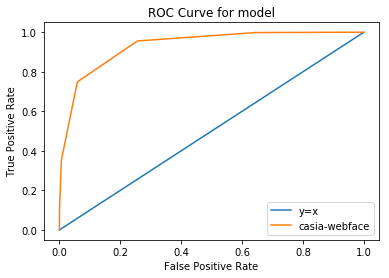

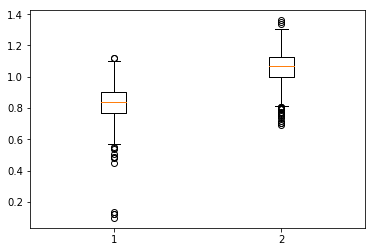

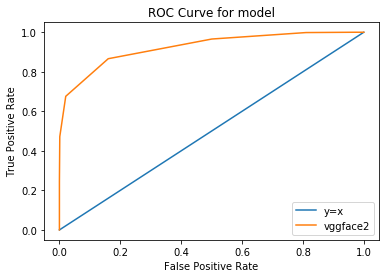

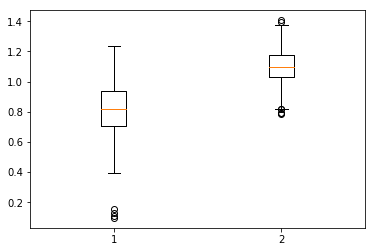

In [11]:
person_a = build_person("n000029", path_for_id_robust_0p5)
person_b = build_person("n000958", path_for_id_robust_0p5)
do_network("casia-webface", person_a, person_b)
do_network("vggface2", person_a, person_b)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
self distance shape (50, 50)
negative distance shape (2500,)
Computed ROC AUC: 0.599
**** Computing ROC curve *****
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
self distance shape (50, 50)
negative distance shape (2500,)
Computed ROC AUC: 0.693
**** Computing ROC curve *****


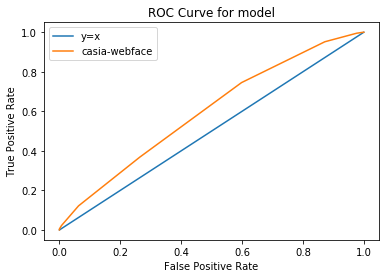

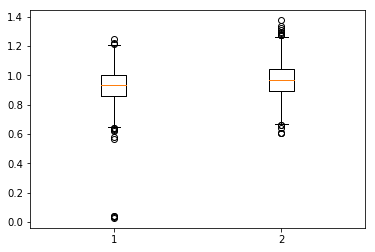

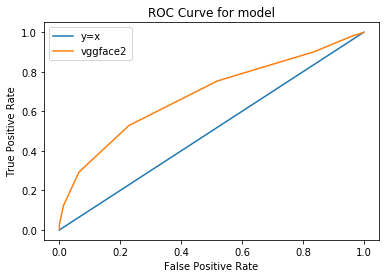

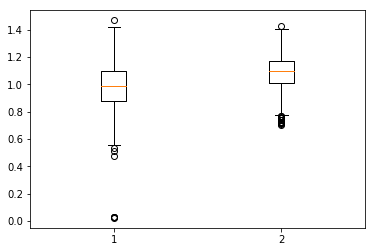

In [12]:
person_a = build_person("n000029", path_for_id_mean_0p1)
person_b = build_person("n000958", path_for_id_mean_0p1)
do_network("casia-webface", person_a, person_b)
do_network("vggface2", person_a, person_b)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90
self distance shape (50, 50)
negative distance shape (2500,)
Computed ROC AUC: 0.867
**** Computing ROC curve *****
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
self distance shape (50, 50)
negative distance shape (2500,)
Computed ROC AUC: 0.938
**** Computing ROC curve *****


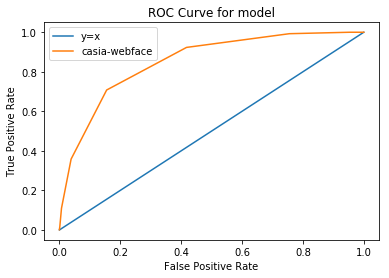

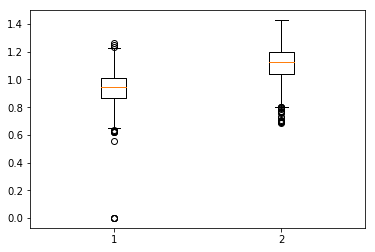

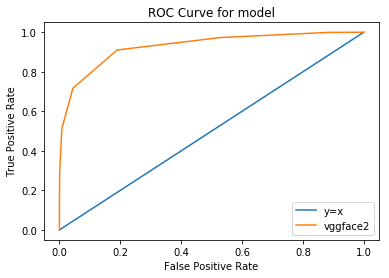

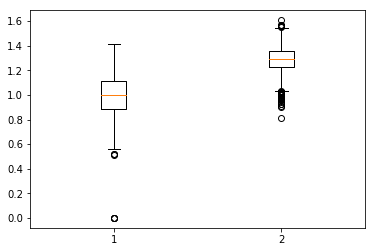

In [13]:
person_a = build_person("n000029", path_for_id_clean)
person_b = build_person("n000958", path_for_id_clean)
do_network("casia-webface", person_a, person_b)
do_network("vggface2", person_a, person_b)

In [23]:
class FacialVectorsDatabase:
    def __init__(self, folder, model_name, epsilon, attack_strategy, image_format, include_adversarial=True):
        self.associated_identities = []
        self.vectors = []
        self.associated_paths = []
#         self.seen_images = set()
        
        identities = os.listdir(folder)
        
        # We have 19 identities with 50 photos each.
        # To ensure non-repeatability of the photo used, generate a permutation of 38 
        # of the 50 indices possible. 
        # We will then use the first two for clean images, and the remaining as decoys. 
        all_indices = np.random.choice(50, 38, replace=False)
        
        self.graph = tf.Graph()
        
        with self.graph.as_default():
            self.model = build_model(model_name)

            for person_name in tqdm(identities):
                attack_subfolder = os.path.join(folder, person_name, attack_strategy)

                protected = os.listdir(attack_subfolder)
                
                # Use the first two indices as clean.
                clean_folder = os.path.join(
                    attack_subfolder, protected[0], "epsilon_0.0", image_format)

                if include_adversarial:
                    self._add_folder_for_person(clean_folder, person_name, all_indices[0:2])

                    for indx, other_identity in enumerate(protected):
                        protected_folder = os.path.join(
                            attack_subfolder, 
                            other_identity, 
                            "epsilon_{eps}".format(eps=epsilon), 
                            image_format
                        )

                        # Use the remaining indices for the decoys, two per person.
                        self._add_folder_for_person(
                            protected_folder, 
                            person_name, 
                            all_indices[indx + 2 : indx + 4]
                        )
                else:
                    self._add_folder_for_person(clean_folder, person_name, all_indices)
                
            
    def _load_one_facenet(self, path, crop_box=None, resize_size=None, prewhiten_img=True):
        img = Image.open(path).convert("RGB")
        
        if crop_box:
            img = img.crop(crop_box)
            
        if resize_size:
            img = img.resize((resize_size, resize_size))
            
        img = (np.array(img)).astype(np.float32)
        
        if prewhiten_img:
            img = prewhiten(img)
            
        return img
        

    def _load_folder_for_facenet(self, folder, indices):
#         paths_list = glob.glob(os.path.join(folder, "*"))
        
#         if num_imgs > 0: 
#             paths_list = np.random.choice(paths_list, num_imgs)
            
#         if num_imgs > 0:
#             paths_list = [path if path.split("/")[-1] not in self.seen_images for path in paths_list]
#             if len(paths_list) < 1:
#                 print("All images seen in {folder}, skipping".format(folder=folder))
#                 return None, None
#             elif len(paths_list) > num_imgs:
#                  paths_list = np.random.choice(paths_list, num_imgs)
                    
#         elif num_imgs == 0:
#             return None, None
        
        paths_list = [os.path.join(folder, "{}.png".format(x)) for x in indices]
        final_imgs = [
            self._load_one_facenet(
                img_path, 
                prewhiten_img=False, 
                resize_size=None, 
                crop_box=None) for img_path in paths_list
        ]

        final_imgs = np.array(final_imgs)
        final_imgs = prewhiten(np.array(final_imgs))
        return final_imgs, paths_list

    
    def _compute_embeddings(self, images):
        return l2_normalize(self.model.predict(np.array(images), batch_size=len(images)))
    
    
    def _add_folder_for_person(self, folder, person_name, indices):
#         if num_imgs < 1:
#             return
        
        images, paths_list = self._load_folder_for_facenet(folder, indices)
        
        if images is None:
            return
#             self.seen_images.add([path.split("/")[-1] for path in paths_list])
        vectors = self._compute_embeddings(images)
        self.vectors.extend(vectors)
        self.associated_identities.extend([person_name for _ in range(len(vectors))])
        self.associated_paths.extend(paths_list)
    
    def nearest_neighbor_to_img_at_path(self, query_path):
        with self.graph.as_default():
            query_vector = self._compute_embeddings(
                np.expand_dims(self._load_one_facenet(query_path, resize_size=160), axis=0))
        distances = pairwise_distances(query_vector, self.vectors)[0]
        min_dist_indx = np.argmin(distances)
        return self.associated_identities[min_dist_indx], self.associated_paths[min_dist_indx]

In [22]:
def full_path_to_info(path):
    split = path.split("/")
    if path.startswith("/data/vggface/test_perturbed_sampled"):
        # split of path breaks down like this:
        #     0 
        #     1 data
        #     2 vggface
        #     3 test_perturbed_sampled
        #     4 {protector}
        #     5 community_naive_mean
        #     6 {protected}
        #     7 epsilon_0.0
        #     8 png
        #     9 35.png
        return "-".join([split[4], split[6], split[7], split[9]])
    else:
        # split of path breaks down like this:
        #     0 
        #     1 data
        #     2 vggface
        #     3 test_query_antisampled
        #     4 {protector}
        #     5 image_name.jpeg
        return "-".join([split[4], split[5]])
        

def measure_local_recall(
    faces_database,
    image_directory="/data/vggface/test_query_antisampled",
    num_query=10,
    verbose=False
):
    discovery = []
    true = []
    identified_as = []
    
    paths_of_query = []
    paths_of_nearest = []

    for protector in os.listdir(image_directory):
        # We are sourcing query photos from epsilon_0.0.
        # In those cases, all subfolders in the "protected" identity have the same, clean
        # photo of the protector, so we just pick any single one that exists (e.g. n000958)
        # For the case where n000958 is itself the protector, n000958 is not present in its protected
        # subfolders, so we pick n000029 without loss of generality.
        if protector == "n000958":
            protected = "n000029"
        else:
            protected = "n000958"

        query_photos_paths = sorted(glob.glob(
            os.path.join(image_directory, protector, "*")
        ))

        
        for i in np.random.choice(len(query_photos_paths), num_query):
            chosen_path = query_photos_paths[i]
            top_identity, top_identity_path = faces_database.nearest_neighbor_to_img_at_path(chosen_path)
            
            paths_of_query.append(full_path_to_info(chosen_path))
            paths_of_nearest.append(full_path_to_info(top_identity_path))
            
            true.append(protector)
            identified_as.append(top_identity)

            if top_identity == protector:
                discovery.append(1.0)
            else:
                discovery.append(0.0)

    if verbose:
        for true_id, recognized_id, query, nearest in zip(true, identified_as, paths_of_query, paths_of_nearest):
            print("Face of {true_id} identitifed as {recognized_id}. Nearest neighbor to {query} was {nearest}".format(
                true_id=true_id, recognized_id=recognized_id, query=query, nearest=nearest))
        
    return sum(discovery)/len(discovery)

def repeat_recall_at_1(dataset_name, include_adversarial=True):
    recall_at_1 = []
    for i in tqdm(range(10)):
        faces_db = FacialVectorsDatabase(
            folder="/data/vggface/test_perturbed_sampled",
            model_name=dataset_name,
            epsilon=0.1,
            attack_strategy="community_naive_mean",
            image_format="png",
            include_adversarial=include_adversarial
        )
        recall_at_1.append(measure_local_recall(faces_db, num_query=10, verbose=False))
        faces_db.model.sess.close()
    return recall_at_1 

In [28]:
vggface_recall_with_adversarial  = repeat_recall_at_1("vggface2", include_adversarial=True)

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 10%|█         | 1/10 [01:14<11:10, 74.47s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 20%|██        | 2/10 [02:16<09:26, 70.81s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 30%|███       | 3/10 [03:24<08:09, 69.94s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 40%|████      | 4/10 [04:37<07:04, 70.70s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 50%|█████     | 5/10 [05:50<05:57, 71.46s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 60%|██████    | 6/10 [07:10<04:56, 74.08s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 70%|███████   | 7/10 [08:13<03:31, 70.61s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 80%|████████  | 8/10 [09:10<02:13, 66.55s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 90%|█████████ | 9/10 [10:05<01:03, 63.15s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



100%|██████████| 10/10 [11:01<00:00, 66.10s/it]


In [27]:
casiawebface_recall_with_adversarial = repeat_recall_at_1("casia-webface", include_adversarial=True)

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 10%|█         | 1/10 [01:03<09:32, 63.57s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 20%|██        | 2/10 [02:08<08:32, 64.12s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 30%|███       | 3/10 [03:16<07:36, 65.18s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 40%|████      | 4/10 [04:28<06:42, 67.04s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 50%|█████     | 5/10 [05:45<05:51, 70.28s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 60%|██████    | 6/10 [06:53<04:38, 69.50s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 70%|███████   | 7/10 [08:00<03:26, 68.80s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 80%|████████  | 8/10 [09:09<02:17, 68.70s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 90%|█████████ | 9/10 [10:15<01:07, 67.99s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



100%|██████████| 10/10 [11:24<00:00, 68.43s/it]


In [29]:
print("Casia WebFace network")
print("Average recall at k=1", np.mean(casiawebface_recall_with_adversarial), end=' ')
print("with standard deviation over 10 runs", np.std(casiawebface_recall_with_adversarial))

Casia WebFace network
Average recall at k=1 0.5573684210526315 with standard deviation over 10 runs 0.03414568754380756


In [30]:
print("VGGFace network")
print("Average recall at k=1", np.mean(vggface_recall_with_adversarial), end=' ')
print("with standard deviation over 10 runs", np.std(vggface_recall_with_adversarial))

VGGFace network
Average recall at k=1 0.8294736842105263 with standard deviation over 10 runs 0.020814442035037035


{'boxes': [<matplotlib.lines.Line2D at 0x7ff9277450f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff9277458d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff9277422e8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff927745f60>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff927745240>,
  <matplotlib.lines.Line2D at 0x7ff927742cc0>]}

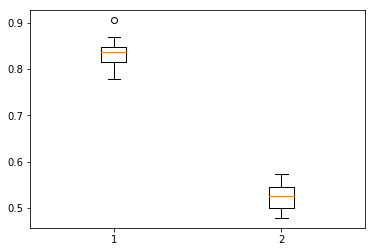

In [21]:
fig1, ax1 = plt.subplots()
ax1.boxplot([vggface_recall_with_adversarial, casiawebface_recall_with_adversarial])

In [24]:
vggface_recall = repeat_recall_at_1("vggface2", include_adversarial=False)

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 10%|█         | 1/10 [00:58<08:43, 58.14s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 20%|██        | 2/10 [01:53<07:39, 57.39s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 30%|███       | 3/10 [02:56<06:52, 58.98s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 40%|████      | 4/10 [04:01<06:04, 60.67s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 50%|█████     | 5/10 [05:03<05:05, 61.12s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 60%|██████    | 6/10 [06:01<04:01, 60.34s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 70%|███████   | 7/10 [06:59<02:58, 59.49s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 80%|████████  | 8/10 [08:03<02:01, 60.95s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



 90%|█████████ | 9/10 [09:00<00:59, 59.77s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275



100%|██████████| 10/10 [09:54<00:00, 59.46s/it]


In [25]:
casiawebface_recall = repeat_recall_at_1("casia-webface", include_adversarial=False)

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 10%|█         | 1/10 [00:58<08:43, 58.16s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 20%|██        | 2/10 [01:57<07:48, 58.53s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 30%|███       | 3/10 [02:58<06:54, 59.17s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 40%|████      | 4/10 [03:49<05:40, 56.72s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 50%|█████     | 5/10 [04:40<04:35, 55.01s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 60%|██████    | 6/10 [05:28<03:32, 53.11s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 70%|███████   | 7/10 [06:24<02:41, 53.80s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 80%|████████  | 8/10 [07:22<01:50, 55.00s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



 90%|█████████ | 9/10 [08:17<00:55, 55.13s/it]

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180408-102900/model-20180408-102900.ckpt-90



100%|██████████| 10/10 [09:17<00:00, 55.72s/it]


{'boxes': [<matplotlib.lines.Line2D at 0x7ffa02331ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x7ffa0232a2e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ffa0232acc0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ffa0232a978>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7ffa02331c18>,
  <matplotlib.lines.Line2D at 0x7ffa022076d8>]}

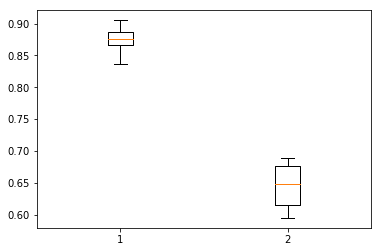

In [26]:
fig1, ax1 = plt.subplots()
ax1.boxplot([vggface_recall, casiawebface_recall])

In [31]:
print("Casia WebFace network")
print("Average recall at k=1", np.mean(casiawebface_recall), end=' ')
print("with standard deviation over 10 runs", np.std(casiawebface_recall))

Casia WebFace network
Average recall at k=1 0.6452631578947369 with standard deviation over 10 runs 0.033303772672750274


In [32]:
print("VGGFace network")
print("Average recall at k=1", np.mean(vggface_recall), end=' ')
print("with standard deviation over 10 runs", np.std(vggface_recall))

VGGFace network
Average recall at k=1 0.8757894736842106 with standard deviation over 10 runs 0.01915095305122131
